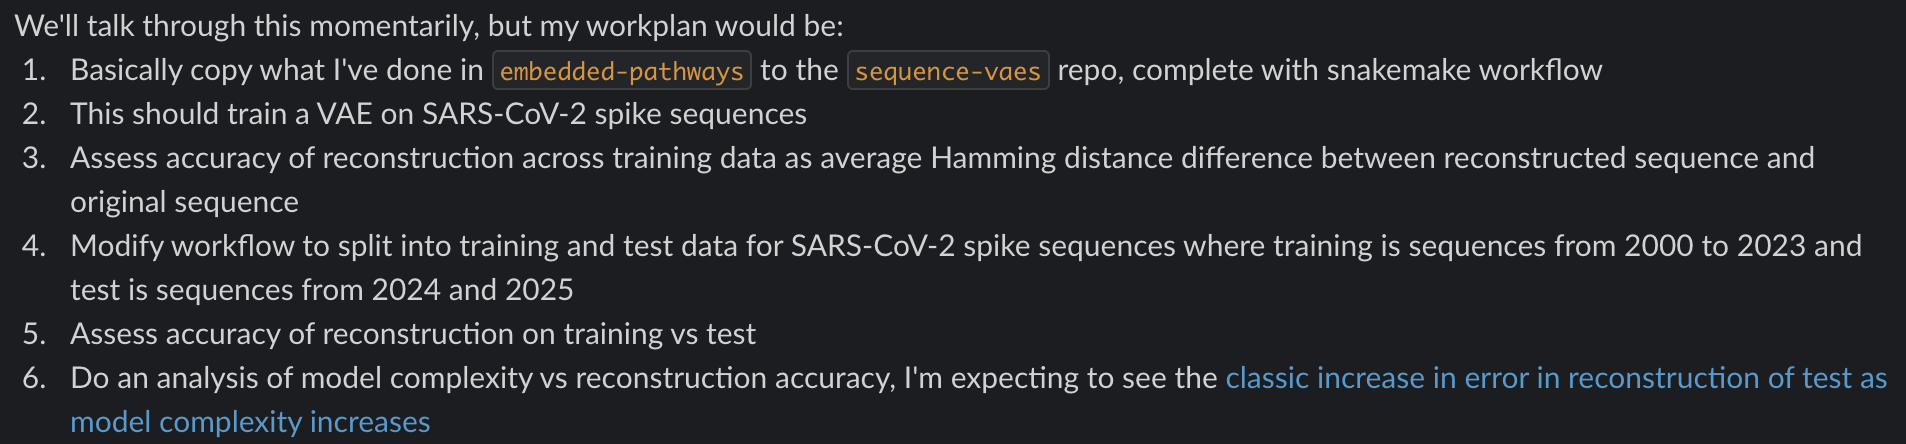

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys

%cd "/content/drive/MyDrive/bedford_lab/code/embedded-pathways"
!pip install -r requirements.txt

In [34]:
sys.path.append("/content/drive/MyDrive/bedford_lab/code/embedded-pathways/latent-diffusion")
from models import VAE, DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import numpy as np

In [24]:
BATCH_SIZE = 64

dataset = DNADataset("/content/drive/MyDrive/bedford_lab/code/embedded-pathways/data/alignment.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [38]:
class Encoder(nn.Module):
  def __init__(self, input_dim, latent_dim, non_linear_activation):
    super().__init__()
    self.input_channels = len(ALPHABET)
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.non_linear_activation = non_linear_activation

    self.seq_len = input_dim

    self.encode = nn.Sequential(
      nn.Linear(self.seq_len, 512),
      self.non_linear_activation,
      nn.Linear(512, 256),
      self.non_linear_activation
   )
    self.fc_mean = nn.Linear(256, self.latent_dim)
    self.fc_logvar = nn.Linear(256, self.latent_dim)

  def forward(self, x):
    x = self.encode(x)
    mean = self.fc_mean(x)
    log_var = self.fc_logvar(x)
    return mean, log_var

In [39]:
class Decoder(nn.Module):
  def __init__(self, input_dim, latent_dim, non_linear_activation):
    super().__init__()
    self.input_channels = len(ALPHABET)
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.non_linear_activation = non_linear_activation
    # self.last_non_linear_activation = nn.Sigmoid()

    self.means = nn.ModuleList([
      nn.Linear(self.latent_dim, 256),
      nn.Linear(256,512),
      nn.Linear(512, self.input_dim * self.input_channels) # last layer
    ])

    for mu in self.means:
      nn.init.constant_(mu.bias,0.1)

  def forward(self, x):
    for i in range(2):
      x = self.means[i](x)
      x = self.non_linear_activation(x)

    x = self.means[-1](x)
    # x = self.last_non_linear_activation(x)
    x = x.view(-1,self.input_dim, self.input_channels)
    # x = F.softmax(x, dim=-1)
    x = F.log_softmax(x, dim=-1)
    x = x.view(-1,self.input_dim * self.input_channels)
    return x

In [40]:
class VAE(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super().__init__()
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.non_linear_activation = nn.ReLU()

    self.encoder = Encoder(input_dim, latent_dim, self.non_linear_activation)
    self.decoder = Decoder(input_dim // len(ALPHABET), latent_dim, self.non_linear_activation)

  # def sample_latent(self, mean, log_var):
  #   eps = torch.randn_like(mean)
  #   std = torch.exp(0.5 * log_var)
  #   return torch.mul(eps, std) + mean

  def train_vae(self, dataloader, epochs, optimizer):
    mse_loss = nn.MSELoss()
    for epoch in range(epochs):
      self.train()
      epoch_loss = 0.0
      epoch_recon_loss = 0.0
      epoch_kl_loss = 0.0
      for i, record_set in enumerate(dataloader):
        batch, _ = record_set  # Unpack sequence tensor and record_id
        # batch = batch.to(DEVICE)
        batch = batch.view(batch.size(0), -1).to(DEVICE)  # Flatten one-hot sequences

        # Train VAE
        mean, logvar = self.encoder.forward(batch)

        eps = torch.randn_like(mean)
        std = torch.exp(0.5 * logvar)
        z = torch.mul(eps, std) + mean

        recon = self.decoder.forward(z)

        recon_loss = F.binary_cross_entropy_with_logits(recon, batch, reduction='sum') / batch.shape[0]
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / batch.shape[0]
        beta = 0.1  # tunable parameter
        vae_loss = recon_loss + beta * kl_loss

        optimizer.zero_grad()
        vae_loss.backward()
        optimizer.step()

        epoch_loss += vae_loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()


      print(f"Epoch {epoch+1}/{epochs} - VAE Loss: {epoch_loss / len(dataloader):.4f} - Reconstruction Loss: {epoch_recon_loss / len(dataloader):.4f} - KL Loss: {epoch_kl_loss / len(dataloader):.4f}")

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [21]:
del vae_model.encoder
del vae_model.decoder
del vae_model

In [41]:
# input_dim = len(ALPHABET) * SEQ_LENGTH
input_dim = 29903 * 5
# input_dim = 29903
vae_model = VAE(input_dim=input_dim, latent_dim=200).to(DEVICE)

In [ ]:
for param in vae_model.encoder.parameters():
  print(param)
  print(param.shape)
  print()

In [ ]:
EPOCHS = 15
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
vae_model.train_vae(dataloader, EPOCHS, optimizer)

In [43]:
dataset = DNADataset("/content/drive/MyDrive/bedford_lab/code/embedded-pathways/data/alignment.fasta")
new_dataset = np.array([dataset[x][0] for x in range(len(dataset))])

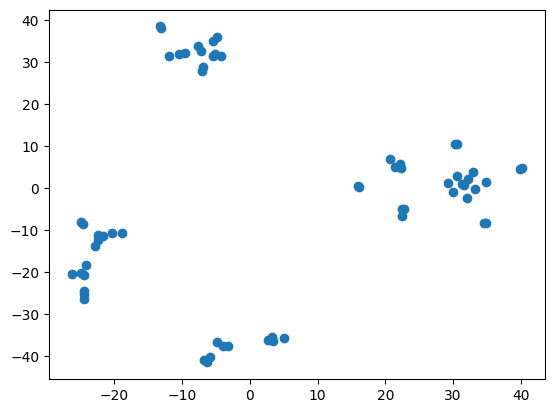

In [42]:
for j in range(1):
  X, _ = next(iter(dataloader))
  # X = X.to(DEVICE)
  X = X.view(X.size(0), -1).to(DEVICE)
  pca = PCA(n_components=2)
  with torch.no_grad():
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()

    max_avg_diff_mean = 0
    max_avg_diff_std = 0

    Z_embedded_tsne = tsne(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X = Z_mean)
    plt.scatter(Z_embedded_tsne[:,0], Z_embedded_tsne[:,1])
plt.show()

In [50]:
import pandas as pd
test = pd.read_csv("/content/drive/MyDrive/bedford_lab/code/embedded-pathways/data/metadata.tsv", sep="\t")

In [ ]:
with open("/content/drive/MyDrive/bedford_lab/code/embedded-pathways/data/alignment.fasta", "r") as f:
  doc = f.readlines()

In [52]:
print(test)

                           name        parent clade_membership  S1_mutations
0               Wuhan/Hu-1/2019  NODE_0000000              19A           0.0
1           USA/WA-UW-1280/2020  NODE_0000003              19B           1.0
2        Australia/QLD1738/2021  NODE_0000004              19B           6.0
3    USA/CA-LACPHL-AF01176/2021  NODE_0000004              19B           4.0
4                  NODE_0000004  NODE_0000003              19B           1.0
..                          ...           ...              ...           ...
461                NODE_0000066  NODE_0000009              20A           1.0
462                NODE_0000009  NODE_0000008              20A           1.0
463                NODE_0000008  NODE_0000010              19A           0.0
464                NODE_0000010  NODE_0000000              19A           0.0
465                NODE_0000000           NaN              19A           0.0

[466 rows x 4 columns]
